In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import os
#import csv
import pandas as pd
import matplotlib 
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap
pylab.rcParams['figure.figsize'] = 12, 8
pd.options.display.mpl_style = 'default'
%matplotlib inline

# Import any observation data
date_spec = {'Date': [ 2]}
observations = pd.read_csv('sciencecenterobservations.csv', sep = ',', parse_dates = date_spec, keep_date_col=True, index_col=0)
observations.TMAX = observations.TMAX/10. 
observations.index = observations.index + pd.DateOffset(hours = 15)

observations2 = pd.read_csv('sciencecenterobservations.csv', sep = ',', parse_dates = date_spec, keep_date_col=True, index_col=0)
observations2.index = observations2.index + pd.DateOffset(hours = 5)
observations2.TMIN = observations2.TMIN/10. 

urban = observations.TMAX.combine_first(observations2.TMIN)

observations = pd.read_csv('bwiobservations.csv', sep = ',', parse_dates = date_spec, keep_date_col=True, index_col=0)
observations.TMAX = observations.TMAX/10. 
observations.index = observations.index + pd.DateOffset(hours = 15)

observations2 = pd.read_csv('bwiobservations.csv', sep = ',', parse_dates = date_spec, keep_date_col=True, index_col=0)
observations2.index = observations2.index + pd.DateOffset(hours = 5)
observations2.TMIN = observations2.TMIN/10. 

rural = observations.TMAX.combine_first(observations2.TMIN)
observations = pd.DataFrame(data = [urban, rural], index = ['urban', 'rural']).T
#observations.rename(columns = ('u', 'r'))
#observations.rural

# read in all files in current directory, assuming that they have the file struction nt.csv or nh.csv, eg 1t.csv, 13t.csv, 40h.csv, etc 
files = glob.glob('*[tT].csv') # read in data files 

meta = pd.DataFrame(pd.read_csv('bmoremetadata.csv', sep = ',')) # read in metadata 
meta = meta.set_index(meta['sensornumber']) # set the row names for metadata to be the sensor number

for index in meta.index: # loop over the sensor numbers in metadata and check if they are numbers
    try: 
        if str.isdigit(index)== 0: 
            meta = meta.drop(meta.loc[index]) # delete the rows without sensor numbers
    except (TypeError):
        pass
        
meta = meta.sort(axis=0) # sort the data in order of the sensor number 
meta = meta.set_index(meta['sensornumber'].astype(int))
# read in all the csv files into a Panda's dataframe, skipping the headers of the csv files
frames = []
sensornumbers = []
date_spec = {'Date': [ 0]}
for file in files: 
    try : 
        frames.append(pd.read_csv(file, sep = ',', skiprows = 19, parse_dates = date_spec, keep_date_col=True))
        sensornumbers.append(int(os.path.splitext(file)[0][0:-1]) )
    except ValueError: 
        print "oops... something went wrong"
    
data = pd.concat(frames, axis =1)

# Clean up data and build a new dataset
# next, normalize the dates: the sensors probably weren't set to all go off at the same time
# assume they all are within an hour of each other
maxStart = data['Date'].values[0,:].max() # the start time of the last sensor to start
minEndIndex = pd.isnull(data['Date']).any(1).nonzero()[0].min() # find the earliest row instance of Nans
maxEnd = data['Date'].values[minEndIndex-1,:].max() #picks the latest time in that row
rng = pd.date_range(maxStart, maxEnd, freq='H') # make a date range from maxStart to maxEnd, with hourly frequency

Temp = data['Value'].values[0:minEndIndex,:] #The temperature data 
clim = Temp.mean(axis=1) # the temperature 'climatology'
anomaly = Temp - np.tile(clim[:,np.newaxis], (1, Temp.shape[1])) # the anomaly data

# produces a data structure with time from variable rng as the rows and sensornumbers as the column heading
# the column 
tempDF = pd.DataFrame(data['Value'].values[0:minEndIndex,:], rng[:], sensornumbers).sort(axis=1)
anomalyDF = pd.DataFrame(anomaly, rng[:], sensornumbers).sort(axis=1)

#clean the metadata so that missing sensors don't mess with analysis
meta = meta.loc[np.intersect1d(tempDF.columns.values, meta.sensornumber.values)]

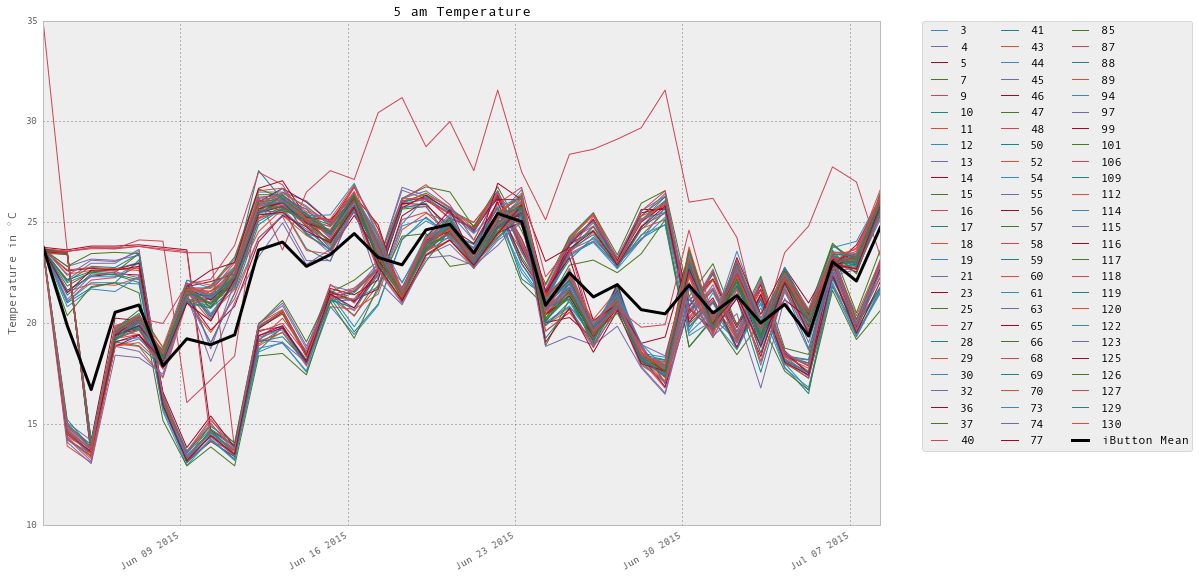

In [13]:
tempDF[tempDF.index.hour ==6].plot(figsize=(15, 10))
tempDF[tempDF.index.hour ==6].mean(axis=1).plot(style = 'k', label = 'iButton Mean', linewidth = 3)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 3)
plt.title('5 am Temperature')
plt.ylabel('Temperature in $^\circ $C')

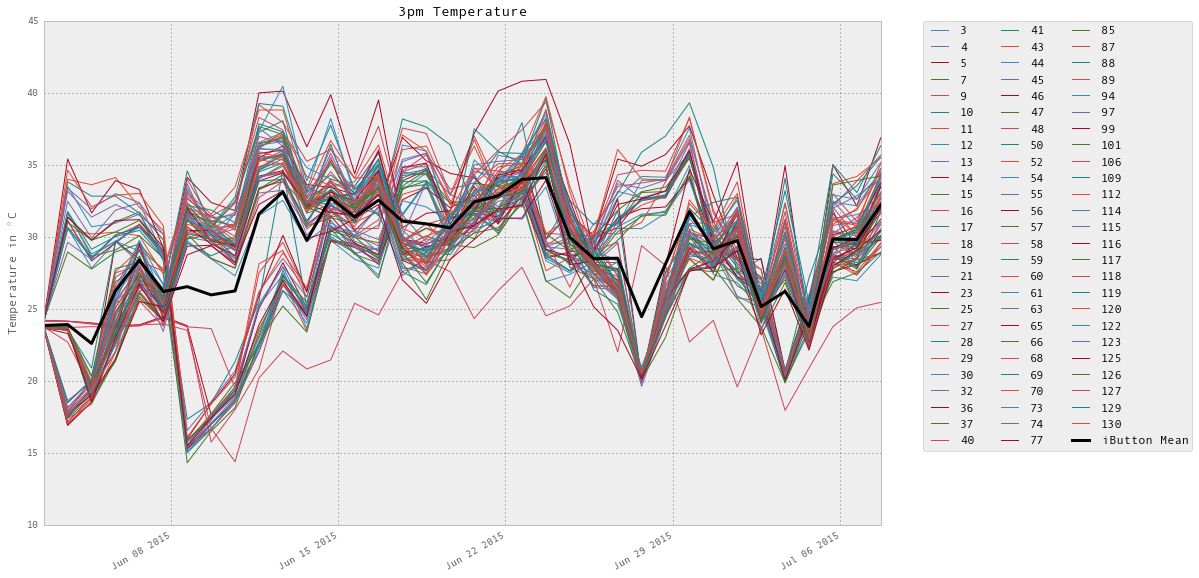

In [12]:
tempDF[tempDF.index.hour ==16].plot(figsize=(15, 10))
tempDF[tempDF.index.hour ==16].mean(axis=1).plot(style = 'k', label = 'iButton Mean', linewidth = 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 3)
plt.title('3pm Temperature')
plt.ylabel('Temperature in $^\circ $C')